In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
notebook_path = os.path.abspath(os.path.join(os.getcwd(), '../notebooks'))
input_file_path = rf'{notebook_path}\data\processed\session'
model_output_filepath = rf'{notebook_path}\output\model'

In [89]:
# Step 1: Loading the Data
year = "2023"
ccy = "gbpusd"
session = "london_afternoon"
file_path = rf'{input_file_path}/{year}_{ccy}_{session}_tick_prev_price_as_base.csv'

# Load the dataset
df = pd.read_csv(file_path)
print(df['datetime'].size)

# Ensure 'datetime' column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'], errors='raise')
# Keep a copy of the 'datetime' column before setting it as the index
df['datetime_original'] = df['datetime']  # Add a backup column
# Run through each line to remove the timezone info

# Feature Engineering
# Create lagged features
lags = [1, 2, 3]
for lag in lags:
    df[f'lag_{lag}'] = df['price'].shift(lag)

# Include `ticks_moved` as a feature
df['ticks_moved_lag_1'] = df['ticks_moved'].shift(1)  # Add lagged `ticks_moved`

# Fill missing values (introduced by lags)
df.dropna(inplace=True)

# Step 3: Define Features and Target
features = [col for col in df.columns if col.startswith('lag') or 'ticks_moved' in col]
df['target'] = (df['directions'] > 0).astype(int)  # Binary target: 1 for up, 0 for down

df['datetime'] = df['datetime'].apply(lambda x: x.replace(tzinfo=None))
# Set 'datetime' as the index
df.set_index('datetime', inplace=True)
# Convert the index to DatetimeIndex explicitly
df.index = pd.to_datetime(df.index, errors='raise')


# Verify that the index is a DatetimeIndex
if not isinstance(df.index, pd.DatetimeIndex):
    raise TypeError("The DataFrame index is not a DatetimeIndex. Ensure 'datetime' is properly converted.")

# Extract the date from the index
df['date'] = df.index.date
unique_dates = df['date'].unique()  # Get unique session days
print(f"Unique session days: {len(unique_dates)}")

# Calculate train-test-backtest split based on unique session days
train_days = int(len(unique_dates) * 0.6)
test_days = int(len(unique_dates) * 0.2)
backtest_days = len(unique_dates) - (train_days + test_days)

# Split session days into train, test, and backtest
train_dates = unique_dates[:train_days]
test_dates = unique_dates[train_days:train_days + test_days]
backtest_dates = unique_dates[train_days + test_days:]
""""
The : slicing syntax is used to extract a portion of the list.
The part before : (in this case, nothing) means "start at the beginning of the list."
The part after : (train_days) means "stop slicing at the index train_days (but not including it)."
"""
print(f"Training days: {len(train_dates)}, Testing days: {len(test_dates)}, Backtesting days: {len(backtest_dates)}")

# Filter the DataFrame for each split
train_data = df[df['date'].isin(train_dates)]
test_data = df[df['date'].isin(test_dates)]
backtest_data = df[df['date'].isin(backtest_dates)]

# Feature Engineering for Each Split
X_train = train_data[features]
y_train = train_data['target']

X_test = test_data[features]
y_test = test_data['target']

X_backtest = backtest_data[features]
y_backtest = backtest_data['target']

# Normalize features (fit only on training data, apply to others)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_backtest_scaled = scaler.transform(X_backtest)

# Step 4: Train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Step 5: Evaluate Model
y_pred_test = rf_model.predict(X_test_scaled)
y_pred_backtest = rf_model.predict(X_backtest_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
classification_report_text = classification_report(y_test, y_pred_test)

# Display Results
results = {
    "Accuracy": accuracy,
    "Confusion Matrix": conf_matrix,
    "Classification Report": classification_report_text
}

print(results)
# Convert the results dictionary into a pandas DataFrame for saving to CSV
results_df = pd.DataFrame.from_dict(
    {key: [value] if not isinstance(value, list) else value for key, value in results.items()}
)
# Save the results DataFrame to CSV
results_df.to_csv(rf'{model_output_filepath}/{year}_{ccy}_{session}_random_forest_results.csv', index=False)

2996
Unique session days: 257
Training days: 154, Testing days: 51, Backtesting days: 52


C:\Users\mmori\AppData\Local\Temp\ipykernel_1588\2090939423.py:12: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['datetime'] = pd.to_datetime(df['datetime'], errors='raise')


{'Accuracy': 0.5236593059936908, 'Confusion Matrix': array([[161, 156],
       [146, 171]]), 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.52      0.51      0.52       317\n           1       0.52      0.54      0.53       317\n\n    accuracy                           0.52       634\n   macro avg       0.52      0.52      0.52       634\nweighted avg       0.52      0.52      0.52       634\n'}


In [90]:
def run_backtest(df, X_test, y_test, y_pred, initial_balance=10000, lot_size=1000):
    """
    Run a simple backtest using model predictions.

    Parameters:
    - df: DataFrame, the original data with features and target.
    - X_test: array, the test feature set. Provides the inputs for the model to generate predictions; indirectly referenced for metadata.
    - y_test: array, the actual target values for the test set. Used to evaluate whether the model's predictions (y_pred) are correct or not.
    - y_pred: array, the predicted target values for the test set. Drives the simulated trades and determines the backtesting outcomes.
    - initial_balance: float, the starting capital for backtesting.
    - lot_size: float, the trade size in units.

    Returns:
    - balance_history: list of balances over time.
    - trade_log: list of trades with details.
    """
    # Initialize variables
    balance = initial_balance
    balance_history = [balance]
    trade_log = []

    for i in range(len(y_pred)):
        actual = y_test.iloc[i]
        predicted = y_pred[i]
        price = df.iloc[len(df) - len(X_test) + i]['price']  # Match test index to df
        
        """
        # Simulate a trade based on predicted direction
        if predicted == 1:  # Buy signal
            trade_profit = (price * 0.0001 * lot_size) if actual == 1 else -(price * 0.0001 * lot_size)
        else:  # Sell signal
            trade_profit = -(price * 0.0001 * lot_size) if actual == 1 else (price * 0.0001 * lot_size)
        """
        # Simulate a trade based on predicted direction: previous balance + direction * lot_size * fx_return
        fx_return = df.iloc[len(df) - len(X_test) + i]['fx_return']  # Match test index to df

        # Simulate a trade based on predicted direction
        if predicted == 1:  # Buy signal
            trade_profit = fx_return * lot_size if actual == 1 else -fx_return * lot_size
        else:  # Sell signal
            trade_profit = -fx_return * lot_size if actual == 1 else fx_return * lot_size

        # Update balance
        balance += trade_profit
        balance_history.append(balance)

        # Log trade
        trade_log.append({
            'tick': df.iloc[len(df) - len(X_test) + i]['tick_number'],
            'datetime': df.iloc[len(df) - len(X_test) + i]['datetime_original'],
            'price': price,
            'predicted': predicted,
            'actual': actual,
            'fx_return':fx_return,
            'profit': trade_profit,
            'balance': balance
        })

    return balance_history, trade_log


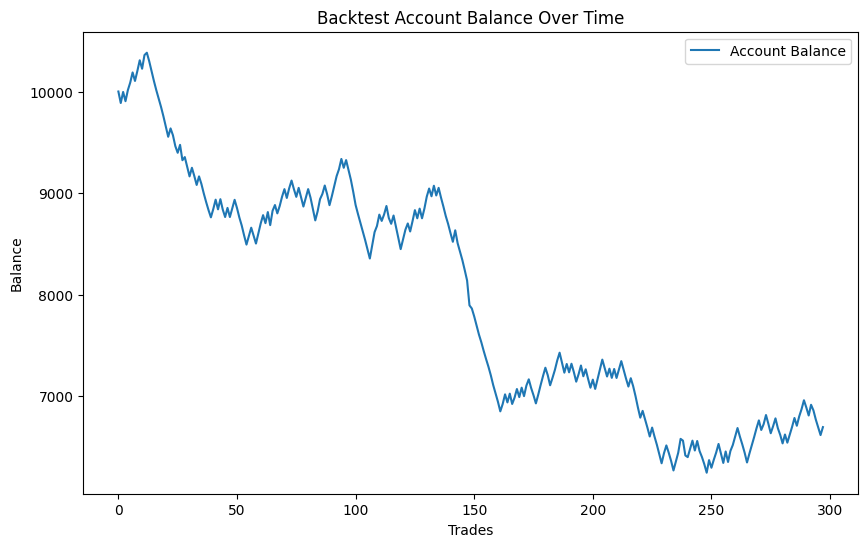

Test set size: 298
     tick                   datetime    price  predicted  actual  fx_return  \
0    5897  2023-10-18 03:10:00-04:00  1.22015          0       1   0.113202   
1    5898  2023-10-18 03:52:00-04:00  1.21915          1       0  -0.108977   
2    5899  2023-10-18 04:16:00-04:00  1.21815          0       0  -0.091050   
3    5900  2023-10-18 04:31:00-04:00  1.21915          1       1   0.109195   
4    5901  2023-10-18 04:47:00-04:00  1.22015          1       1   0.074631   
..    ...                        ...      ...        ...     ...        ...   
292  7236  2023-12-29 04:56:00-05:00  1.27015          0       0  -0.055085   
293  7237  2023-12-29 05:15:00-05:00  1.27115          0       1   0.090546   
294  7238  2023-12-29 05:40:00-05:00  1.27215          0       1   0.074731   
295  7239  2023-12-29 05:58:00-05:00  1.27315          0       1   0.077820   
296  7240  2023-12-29 06:37:00-05:00  1.27415          1       1   0.078545   

         profit       balance  


In [88]:
# Run backtest -> train:test:backtest=60:40:40, backtest using the new data
balance_history, trade_log = run_backtest(backtest_data, X_backtest, y_backtest, y_pred_backtest)

# Convert trade_log to a DataFrame for easier analysis
trade_log_df = pd.DataFrame(trade_log)

# Plot balance history
plt.figure(figsize=(10, 6))
plt.plot(balance_history, label='Account Balance')
plt.title('Backtest Account Balance Over Time')
plt.xlabel('Trades')
plt.ylabel('Balance')
plt.legend()
plt.show()

print(f"Test set size: {len(X_test)}")

# Display trade log
print(trade_log_df)
trade_log_df.to_csv(rf'{model_output_filepath}/{year}_{ccy}_{session}_backtesting.csv')

